In [1]:
## Import library

import pandas as pd 
# import keras
import numpy as np
import matplotlib.pyplot as plt
from cleanlab.classification import CleanLearning
# import tensorflow as tf
# from tensorflow import keras
# from keras import backend as K
from cleanlab import *
from torch import nn
import torch as torch
from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from cleanlab.filter import find_label_issues
from cleanlab.dataset import health_summary


In [2]:
## Load the datas 

fmnist_test = pd.read_csv('fashion-mnist_test.csv')
fmnist_train = pd.read_csv('fashion-mnist_train.csv')

In [3]:
## Sort datas in x and y 

label_fmnist_test = fmnist_test.iloc[:,0]
label_fmnist_train = fmnist_train.iloc[:,0]
fmnist_test = fmnist_test.iloc[:,1:]
fmnist_train = fmnist_train.iloc[:,1:]

In [4]:
##Our label is jsute a number,

label_fmnist_test.shape
Y_test = label_fmnist_test.to_numpy()
Y_test = Y_test.astype('int32')
# Y_test = torch.from_numpy(Y_test)
# print(Y_test)

In [5]:
## Normalize

normalized_fmnist_test = fmnist_test /255
normalized_fmnist_train = fmnist_train /255

In [6]:
## We then constructs our pictures 
fashion_test = np.array(normalized_fmnist_test)
fashion_test = fashion_test.reshape(len(fashion_test),1,28,28)
fashion_test = fashion_test.astype('float32')

fashion_train = np.array(normalized_fmnist_train)
fashion_train = fashion_train.reshape(len(fashion_train),1,28,28)
fashion_train = fashion_train.astype('float32')

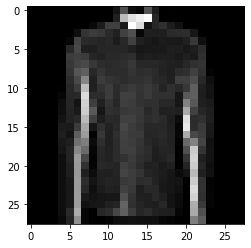

In [7]:
## Show if its good 
exemple_image = fashion_test[77,0,:,:]
plt.imshow(exemple_image, cmap='gray')

In [8]:

class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [10]:
model_skorch = NeuralNetClassifier(ClassifierModule, max_epochs=20)

In [11]:
y = Y_test
X = fashion_test
num_crossval_folds = 5
pred_probs = cross_val_predict(model_skorch, X, y,
                               cv=num_crossval_folds,
                               method='predict_proba')

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7713       0.6344        1.5435  3.6232
      2        1.0984       0.7150        0.9255  0.5755
      3        0.8451       0.7556        0.7714  0.5999
      4        0.7292       0.7688        0.6865  0.5606
      5        0.6580       0.7806        0.6305  0.5343
      6        0.6072       0.7919        0.5890  0.5302
      7        0.5683       0.7963        0.5592  0.5405
      8        0.5369       0.8050        0.5359  0.5308
      9        0.5109       0.8094        0.5188  0.5304
     10        0.4888       0.8163        0.5040  0.5273
     11        0.4697       0.8194        0.4928  0.5245
     12        0.4532       0.8256        0.4839  0.5214
     13        0.4386       0.8275        0.4764  0.5410
     14        0.4255       0.8287        0.4708  0.5326
     15        0.4138       0.8306        0.4644  0.5328
     16        0.4028       0.8

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8746       0.6288        1.6189  0.4705
      2        1.1099       0.7419        0.9157  0.4718
      3        0.7936       0.7731        0.7243  0.6385
      4        0.6696       0.7850        0.6435  0.6628
      5        0.6036       0.7887        0.5972  0.5118
      6        0.5601       0.7987        0.5642  0.6071
      7        0.5276       0.8081        0.5397  0.5536
      8        0.5019       0.8156        0.5211  0.4585
      9        0.4805       0.8163        0.5068  0.4969
     10        0.4623       0.8163        0.4971  0.5469
     11        0.4465       0.8213        0.4840  0.5507
     12        0.4326       0.8237        0.4722  0.5519
     13        0.4196       0.8269        0.4670  0.5401
     14        0.4080       0.8269        0.4574  0.5511
     15        0.3976       0.8306        0.4516  0.5693
     16        0.3874       0.8

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7495       0.6681        1.5048  0.6070
      2        1.0725       0.7356        0.9076  0.5253
      3        0.8157       0.7706        0.7419  0.5483
      4        0.6982       0.7875        0.6556  0.5526
      5        0.6316       0.7981        0.6003  0.5296
      6        0.5872       0.8031        0.5642  0.5566
      7        0.5536       0.8075        0.5363  0.5591
      8        0.5262       0.8187        0.5154  0.4697
      9        0.5027       0.8250        0.4994  0.4247
     10        0.4823       0.8350        0.4845  0.4196
     11        0.4644       0.8400        0.4689  0.4268
     12        0.4487       0.8431        0.4601  0.4264
     13        0.4349       0.8444        0.4498  0.4102
     14        0.4227       0.8462        0.4405  0.4061
     15        0.4116       0.8494        0.4316  0.5724
     16        0.4012       0.8

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7604       0.6562        1.5224  0.5534
      2        1.0853       0.7400        0.9220  0.4880
      3        0.8305       0.7556        0.7699  0.5436
      4        0.7194       0.7694        0.6891  0.5492
      5        0.6532       0.7875        0.6336  0.4392
      6        0.6055       0.7937        0.5932  0.4287
      7        0.5676       0.8063        0.5588  0.4383
      8        0.5360       0.8150        0.5314  0.5673
      9        0.5089       0.8206        0.5082  0.4502
     10        0.4852       0.8269        0.4886  0.4036
     11        0.4644       0.8319        0.4730  0.3977
     12        0.4459       0.8337        0.4608  0.4435
     13        0.4296       0.8375        0.4490  0.4244
     14        0.4151       0.8413        0.4409  0.4515
     15        0.4023       0.8438        0.4317  0.4344
     16        0.3908       0.8

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7066       0.6281        1.6262  0.5110
      2        1.0321       0.7319        0.8900  0.4457
      3        0.8044       0.7538        0.7505  0.5252
      4        0.7025       0.7662        0.6807  0.5545
      5        0.6424       0.7800        0.6335  0.5340
      6        0.6002       0.7900        0.6001  0.4767
      7        0.5675       0.7944        0.5759  0.3929
      8        0.5413       0.7963        0.5560  0.3858
      9        0.5191       0.7994        0.5395  0.4078
     10        0.4997       0.8037        0.5264  0.4392
     11        0.4826       0.8075        0.5153  0.5131
     12        0.4671       0.8075        0.5054  0.5373
     13        0.4529       0.8094        0.4966  0.5655
     14        0.4399       0.8131        0.4889  0.5821
     15        0.4280       0.8169        0.4827  0.5482
     16        0.4168       0.8

In [12]:

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)

print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.8434


In [13]:
method = 'both'
ranked_label_issues = find_label_issues(y, pred_probs,filter_by=method,return_indices_ranked_by="self_confidence")

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print("Here are the indices of the top 15 most likely label errors:\n"
      f"{ranked_label_issues[:15]}")


Cleanlab found 681 label issues.
Here are the indices of the top 15 most likely label errors:
[2900 2128 4451 5927 1922  138 3325 7553  196 6541 9847 5184 5232 2721
 2715]


In [14]:
fashion_dico = {
    '0':'T-shirt/top',
    '1':'Trouser',
    '2':'Pullover',
    '3':'Dress',
    '4':'Coat',
    '5':'Sandal',
    '6':'Shirt',
    '7':'Sneaker',
    '8':'Bag',
    '9':'Ankle boot'
}
def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        fashion_id = str(y[id])
        plt.title(f"id: {id} \n label: {fashion_dico[fashion_id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)

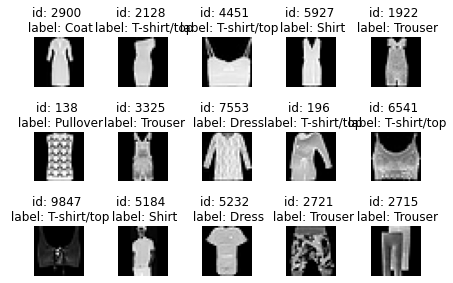

In [15]:
plot_examples(ranked_label_issues[range(15)], 3, 5)

In [16]:
health_summary(y, pred_probs)

------------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary            |
|   for your dataset with 10,000 examples and 10 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.          |
------------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,6,302,326,0.302,0.318359,0.698
1,2,167,123,0.167,0.128661,0.833
2,4,157,173,0.157,0.170276,0.843
3,0,109,159,0.109,0.151429,0.891
4,3,55,32,0.055,0.032753,0.945
5,8,21,12,0.021,0.012109,0.979
6,5,20,12,0.020,0.012097,0.980
7,9,18,18,0.018,0.018000,0.982
8,7,17,26,0.017,0.025768,0.983
9,1,15,0,0.015,0.000000,0.985



Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,0,6,229,0.0229
1,4,6,193,0.0193
2,2,6,154,0.0154
3,2,4,102,0.0102
4,3,6,32,0.0032
5,3,4,29,0.0029
6,7,9,26,0.0026
7,0,2,22,0.0022
8,5,7,17,0.0017
9,6,8,13,0.0013



 * Overall, about 9% (881 of the 10,000) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.91.

Generated with <3 from Cleanlab.



{'overall_label_health_score': 0.9118999999999999,
 'joint': array([[0.0891, 0.    , 0.0016, 0.0005, 0.0002, 0.    , 0.0081, 0.    ,
         0.0005, 0.    ],
        [0.    , 0.0985, 0.0001, 0.0007, 0.    , 0.    , 0.0007, 0.    ,
         0.    , 0.    ],
        [0.0006, 0.    , 0.0833, 0.0001, 0.0071, 0.    , 0.0088, 0.    ,
         0.0001, 0.    ],
        [0.0005, 0.    , 0.0007, 0.0945, 0.0016, 0.    , 0.0027, 0.    ,
         0.    , 0.    ],
        [0.    , 0.    , 0.0031, 0.0013, 0.0843, 0.    , 0.0113, 0.    ,
         0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.098 , 0.    , 0.0012,
         0.0003, 0.0005],
        [0.0148, 0.    , 0.0066, 0.0005, 0.008 , 0.    , 0.0698, 0.    ,
         0.0003, 0.    ],
        [0.    , 0.    , 0.    , 0.    , 0.    , 0.0005, 0.    , 0.0983,
         0.    , 0.0012],
        [0.    , 0.    , 0.0002, 0.0001, 0.0004, 0.0003, 0.001 , 0.    ,
         0.0979, 0.0001],
        [0.    , 0.    , 0.    , 0.    , 0.    , 

In [17]:
from cleanlab.rank import get_label_quality_scores
quality_scores = get_label_quality_scores(y,pred_probs)
for id in range(10):
        print(f"Label: {fashion_dico[str(id)]} has a score of : {quality_scores[id]} \n")

Label: T-shirt/top has a score of : 0.9480812549591064 

Label: Trouser has a score of : 0.9994959831237793 

Label: Pullover has a score of : 0.5910174250602722 

Label: Dress has a score of : 0.5349535942077637 

Label: Coat has a score of : 0.907891035079956 

Label: Sandal has a score of : 0.17675204575061798 

Label: Shirt has a score of : 0.981965959072113 

Label: Sneaker has a score of : 0.3480145037174225 

Label: Bag has a score of : 0.9962186217308044 

Label: Ankle boot has a score of : 0.9926504492759705 



In [18]:
## How to improve the model ?? 

# 3 solutions : 

    # Remove all data that cleanlab deems problematic.
    # Remove data with quality scores below a threshold. We define or remove a set number of data points.
    # Manually mark the data for removal starting from the lowest quality score.

clean_y = np.delete(y, ranked_label_issues)
clean_fashion_test = np.delete(fashion_test, ranked_label_issues,axis=0)
print(f'Shape of orignale Label {y.shape} and of originals X {fashion_test.shape}')
print(f'Shape of updated labels {clean_y.shape} and of updated X {clean_fashion_test.shape}')

Shape of orignale Label (10000,) and of originals X (10000, 1, 28, 28)
Shape of updated labels (9319,) and of updated X (9319, 1, 28, 28)


In [19]:
model_skorch = NeuralNetClassifier(ClassifierModule, max_epochs=20)
num_crossval_folds = 5
clean_pred_probs = cross_val_predict(model_skorch, clean_fashion_test, clean_y,
                               cv=num_crossval_folds,
                               method='predict_proba')

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8092       0.6244        1.8248  0.4963
      2        1.1120       0.7834        0.8801  0.4246
      3        0.7776       0.8129        0.6689  0.4139
      4        0.6344       0.8256        0.5732  0.4451
      5        0.5583       0.8303        0.5197  0.4442
      6        0.5099       0.8357        0.4816  0.4639
      7        0.4749       0.8397        0.4551  0.4805
      8        0.4475       0.8471        0.4361  0.3920
      9        0.4248       0.8504        0.4183  0.3896
     10        0.4054       0.8551        0.4037  0.5016
     11        0.3883       0.8565        0.3907  0.5040
     12        0.3726       0.8592        0.3796  0.3969
     13        0.3587       0.8632        0.3684  0.3806
     14        0.3459       0.8665        0.3594  0.3786
     15        0.3339       0.8672        0.3513  0.3602
     16        0.3227       0.8

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7941       0.6465        1.6688  0.5044
      2        1.0353       0.7626        0.8617  0.5039
      3        0.7572       0.8048        0.6748  0.4994
      4        0.6227       0.8142        0.5835  0.4946
      5        0.5432       0.8296        0.5231  0.4960
      6        0.4891       0.8384        0.4836  0.4976
      7        0.4497       0.8464        0.4550  0.4968
      8        0.4188       0.8504        0.4322  0.4974
      9        0.3937       0.8518        0.4140  0.5371
     10        0.3725       0.8558        0.3985  0.5153
     11        0.3540       0.8585        0.3851  0.4968
     12        0.3377       0.8612        0.3739  0.4980
     13        0.3232       0.8632        0.3641  0.4919
     14        0.3101       0.8699        0.3550  0.4963
     15        0.2980       0.8732        0.3476  0.5036
     16        0.2871       0.8

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7607       0.6935        1.6391  0.4934
      2        1.0647       0.7921        0.8722  0.4998
      3        0.7679       0.8095        0.6816  0.4975
      4        0.6289       0.8209        0.5827  0.4982
      5        0.5477       0.8276        0.5199  0.4871
      6        0.4934       0.8343        0.4776  0.5077
      7        0.4533       0.8457        0.4476  0.5145
      8        0.4217       0.8518        0.4233  0.5217
      9        0.3952       0.8612        0.4030  0.5178
     10        0.3726       0.8659        0.3859  0.5087
     11        0.3529       0.8659        0.3711  0.5121
     12        0.3355       0.8719        0.3585  0.5123
     13        0.3198       0.8786        0.3477  0.5016
     14        0.3056       0.8799        0.3385  0.5146
     15        0.2928       0.8820        0.3307  0.5518
     16        0.2812       0.8

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6984       0.7384        1.3879  0.4846
      2        0.9752       0.7854        0.7922  0.4801
      3        0.7307       0.8055        0.6384  0.4842
      4        0.6161       0.8182        0.5548  0.4842
      5        0.5467       0.8290        0.5020  0.4989
      6        0.4979       0.8377        0.4637  0.4894
      7        0.4597       0.8451        0.4347  0.4894
      8        0.4280       0.8511        0.4095  0.4979
      9        0.4012       0.8585        0.3875  0.4900
     10        0.3780       0.8652        0.3695  0.4921
     11        0.3578       0.8672        0.3543  0.4923
     12        0.3397       0.8699        0.3411  0.4926
     13        0.3239       0.8753        0.3300  0.4907
     14        0.3102       0.8793        0.3202  0.4942
     15        0.2981       0.8820        0.3124  0.4898
     16        0.2872       0.8

/home/craven/miniconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6999       0.6374        1.5084  0.5027
      2        1.0589       0.7567        0.9000  0.4993
      3        0.7790       0.7849        0.7122  0.5011
      4        0.6404       0.7996        0.6144  0.5132
      5        0.5608       0.8123        0.5539  0.4982
      6        0.5078       0.8231        0.5087  0.4968
      7        0.4677       0.8284        0.4767  0.4961
      8        0.4355       0.8378        0.4517  0.4968
      9        0.4084       0.8458        0.4316  0.4961
     10        0.3851       0.8572        0.4138  0.5146
     11        0.3647       0.8606        0.3990  0.5229
     12        0.3465       0.8646        0.3869  0.5260
     13        0.3303       0.8700        0.3776  0.5134
     14        0.3155       0.8767        0.3673  0.5075
     15        0.3023       0.8794        0.3595  0.5146
     16        0.2902       0.8

In [22]:
predicted_labels = clean_pred_probs.argmax(axis=1)
acc = accuracy_score(clean_y, predicted_labels)

print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.8840004292306042


In [ ]:
# before cleanLab : 0.843
# deleting all labels raised by cleanlab : 0.884
